In [3]:
# 2. Imports & Paths
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt

# The linear_models.ipynb is in notebooks/, this goes up one level to repo root
ROOT = Path("..").resolve()

DATA_DIR = ROOT / "data" / "raw" / "bike+sharing+dataset"
DAY_CSV  = DATA_DIR / "day.csv"
HOUR_CSV = DATA_DIR / "hour.csv"

FIG_DIR  = ROOT / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# sanity check
assert DAY_CSV.exists(), f"Can't find {DAY_CSV}"
assert HOUR_CSV.exists(), f"Can't find {HOUR_CSV}"

In [4]:
# Load dataset

day  = pd.read_csv(DAY_CSV)
hour = pd.read_csv(HOUR_CSV)

display(day.head(), hour.head())
print(day.shape, hour.shape)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


(731, 16) (17379, 17)


In [5]:
# 1. Define target & drop leakage cols

TARGET = "cnt"
DROP_COLS = ["instant", "dteday", "casual", "registered", "cnt"]  # IDs + leakage


In [6]:
# 2. Prep X/y

def prep_xy(df):
    X = df.drop(columns=[c for c in DROP_COLS if c in df.columns])
    y = df[TARGET]
    return X, y

X_day,  y_day  = prep_xy(day)
X_hour, y_hour = prep_xy(hour)

In [7]:
# 3. Train/test + pipeline + metrics

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

def build_linear_regression(X, y, test_size=0.2, random_state=42):
    cat_cols = X.select_dtypes(include=["int64", "int32"]).columns.tolist()
    num_cols = X.select_dtypes(include=["float64", "float32"]).columns.tolist()
    
    pre = ColumnTransformer([
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols)
    ])
    
    pipe = Pipeline([
        ("prep", pre),
        ("model", LinearRegression())
    ])
    
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=test_size, random_state=random_state)
    pipe.fit(X_tr, y_tr)
    y_pred = pipe.predict(X_te)
    
    metrics = {
        "R2": r2_score(y_te, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_te, y_pred)),
        "MAE": mean_absolute_error(y_te, y_pred)
    }
    return pipe, (X_tr, X_te, y_tr, y_te, y_pred), metrics

pipe_day,  data_day,  met_day  = build_linear_regression(X_day,  y_day)
pipe_hour, data_hour, met_hour = build_linear_regression(X_hour, y_hour)

print("Daily :", met_day)
print("Hourly:", met_hour)

Daily : {'R2': 0.8418029967286178, 'RMSE': np.float64(796.4617765623753), 'MAE': 583.019758830069}
Hourly: {'R2': 0.6813752375238188, 'RMSE': np.float64(100.44592657638786), 'MAE': 74.1051385360966}


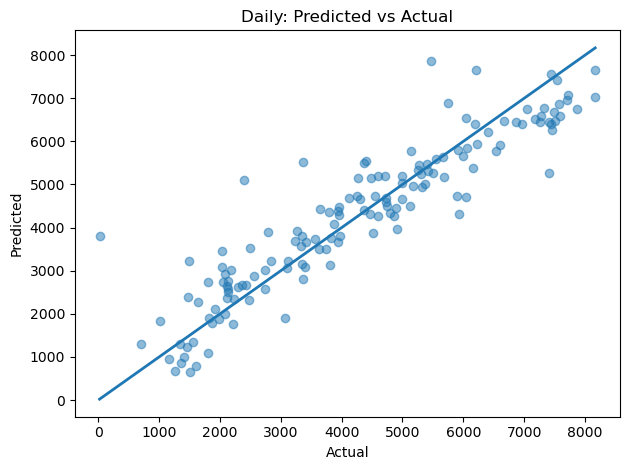

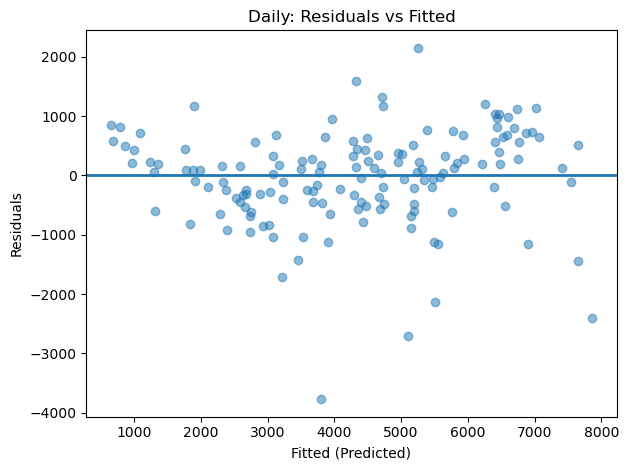

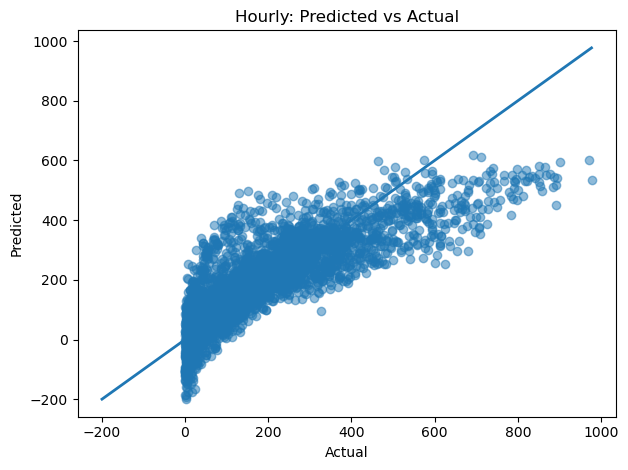

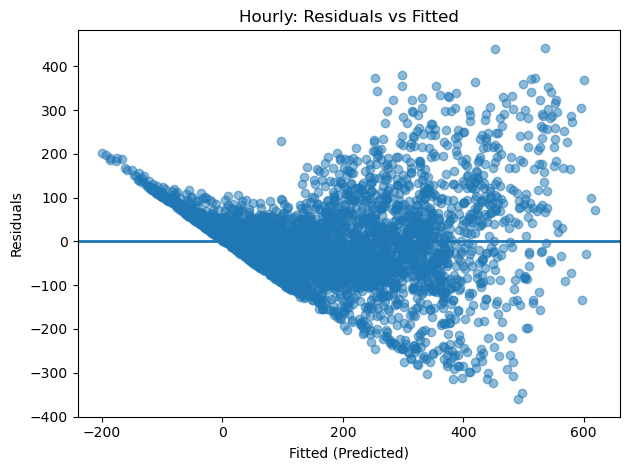

In [8]:
# 4. Diagnostics plots

import matplotlib.pyplot as plt
FIG_DIR.mkdir(parents=True, exist_ok=True)

def diag_plots(y_true, y_pred, title_prefix):
    resid = y_true - y_pred

    # Predicted vs Actual
    plt.figure()
    plt.scatter(y_true, y_pred, alpha=0.5)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    plt.plot(lims, lims, linewidth=2)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{title_prefix}: Predicted vs Actual")
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"{title_prefix}_pred_vs_actual.png", dpi=300)

    # Residuals vs Fitted
    plt.figure()
    plt.scatter(y_pred, resid, alpha=0.5)
    plt.axhline(0, linewidth=2)
    plt.xlabel("Fitted (Predicted)")
    plt.ylabel("Residuals")
    plt.title(f"{title_prefix}: Residuals vs Fitted")
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"{title_prefix}_residuals_vs_fitted.png", dpi=300)

# unpack
Xtr_d, Xte_d, ytr_d, yte_d, ypred_d = data_day
Xtr_h, Xte_h, ytr_h, yte_h, ypred_h = data_hour

diag_plots(yte_d, ypred_d, "Daily")
diag_plots(yte_h, ypred_h, "Hourly")

In [11]:
# 5. Coefficients (to talk about “key drivers”)

REPORT_DIR = Path("../reports")
REPORT_DIR.mkdir(parents=True, exist_ok=True)

def feature_names_from_ct(preprocessor, X):
    """Return correct feature names from a fitted ColumnTransformer."""
    try:
        # sklearn ≥ 1.0
        return preprocessor.get_feature_names_out()
    except AttributeError:
        # Manual fallback for older sklearn
        names = []
        for name, trans, cols in preprocessor.transformers_:
            if name == "remainder":
                continue
            if hasattr(trans, "get_feature_names_out"):
                names.extend(trans.get_feature_names_out(cols))
            else:
                # no get_feature_names_out -> use original column names
                names.extend(cols)
        return np.array(names)

def coef_series(pipe, X):
    pre = pipe.named_steps["prep"]
    feat_names = feature_names_from_ct(pre, X)
    coefs = pd.Series(pipe.named_steps["model"].coef_, index=feat_names)
    coefs_sorted = coefs.reindex(coefs.abs().sort_values(ascending=False).index)
    return coefs, coefs_sorted

# Get coefficients for each model
coef_day,  coef_day_sorted  = coef_series(pipe_day,  X_day)
coef_hour, coef_hour_sorted = coef_series(pipe_hour, X_hour)

# Save full lists
coef_day.to_csv(REPORT_DIR / "daily_coefficients.csv")
coef_hour.to_csv(REPORT_DIR / "hourly_coefficients.csv")

# Show top 15 absolute for quick inspection
display(coef_day_sorted.head(15), coef_hour_sorted.head(15))

cat__weathersit_3   -1048.101800
cat__yr_1             990.917291
cat__yr_0            -990.917291
cat__season_1        -856.293222
cat__season_4         797.949734
cat__weathersit_1     778.270263
num__temp             686.298246
cat__mnth_9           638.731920
cat__mnth_7          -483.829552
cat__mnth_11         -427.074518
cat__mnth_12         -403.449266
cat__mnth_3           369.479996
cat__mnth_5           331.928122
cat__weekday_6        285.515089
cat__weathersit_2     269.831538
dtype: float64

cat__hr_17           257.306540
cat__hr_18           217.101390
cat__hr_8            190.780081
cat__hr_4           -165.119038
cat__hr_3           -162.703611
cat__hr_2           -152.653497
cat__hr_5           -147.100414
cat__hr_1           -142.275927
cat__hr_0           -125.433683
cat__hr_19           110.504167
cat__hr_16           100.354789
cat__hr_23           -92.403851
cat__hr_6            -90.386032
cat__weathersit_4    -76.778815
cat__hr_22           -53.409885
dtype: float64

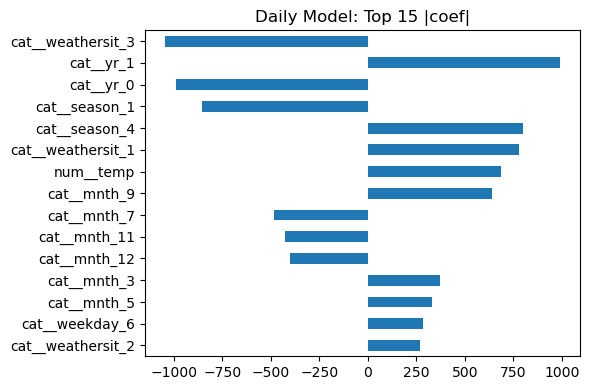

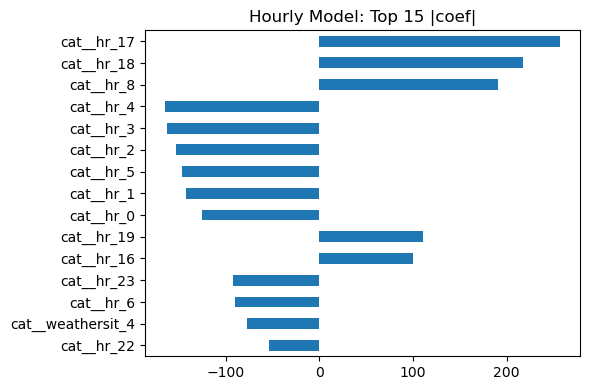

In [12]:
# Quick bar plot of top 15 coefficients

def plot_top_coefs(series, title):
    top = series.head(15)[::-1]  # reverse for horizontal plot
    plt.figure(figsize=(6,4))
    top.plot(kind="barh")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"{title.replace(' ','_')}_top15_coef.png", dpi=300)

plot_top_coefs(coef_day_sorted,  "Daily Model: Top 15 |coef|")
plot_top_coefs(coef_hour_sorted, "Hourly Model: Top 15 |coef|")